In [1]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

BASE_DIR = Path("/Users/vittoriogaravelli/GitHub/GitHub/ERMDA-30464_GP")
DERIVED_DIR = BASE_DIR / "data" / "derived"

print(f"Using data directory: {DERIVED_DIR}")


Using data directory: /Users/vittoriogaravelli/GitHub/GitHub/ERMDA-30464_GP/data/derived


In [2]:
# Load clean datasets and prepare panel
basilicata_path = DERIVED_DIR / "basilicata_filtered.dta"
molise_path = DERIVED_DIR / "molise_filtered.dta"
puglia_path = DERIVED_DIR / "puglia_filtered.dta"

missing_paths = [p for p in [basilicata_path, molise_path, puglia_path] if not p.exists()]
if missing_paths:
    raise FileNotFoundError(
        "Filtered datasets not found. Please run data_analysis.ipynb first. Missing: "
        + ", ".join(str(p) for p in missing_paths)
    )

control_basilicata = pd.read_stata(basilicata_path)
control_basilicata["group"] = "control_basilicata"

control_puglia = pd.read_stata(puglia_path)
control_puglia["group"] = "control_puglia"

treated_molise = pd.read_stata(molise_path)
treated_molise["group"] = "treated_molise"

panel = pd.concat([control_basilicata, control_puglia, treated_molise], ignore_index=True)

GROUP_LABELS = {
    "control_basilicata": "Control (Basilicata)",
    "control_puglia": "Control (Puglia)",
    "treated_molise": "Treated (Molise)",
}

TYPE_LABELS = {
    1: "Employment Type 1",
    2: "Employment Type 2",
    3: "Employment Type 3",
    4: "Employment Type 4",
}

# Ensure types and clean values
panel["year"] = panel["year"].astype("Int64")
panel["employed"] = panel["employed"].fillna(0).astype("Int8")
panel["wage"] = pd.to_numeric(panel["wage"], errors="coerce").fillna(0.0)
panel["type"] = pd.to_numeric(panel["type"], errors="coerce").astype("Int64")

print(panel.head())
print(panel.groupby("group")["id_worker"].nunique())


   id_worker  year  type    wage  contract_type  sector_2d region_res  \
0       2806  1999     1  7000.0            1.0       45.0          2   
1       2806  2003     4     0.0            NaN        NaN          2   
2       2806  1998     4     0.0            NaN        NaN          2   
3       2806  2004     4     0.0            NaN        NaN          2   
4       2806  2005     4     0.0            NaN        NaN          2   

   employed               group  
0         1  control_basilicata  
1         0  control_basilicata  
2         0  control_basilicata  
3         0  control_basilicata  
4         0  control_basilicata  
group
control_basilicata     9875
control_puglia        63923
treated_molise         5431
Name: id_worker, dtype: int64


In [3]:
# Define baseline cohort (employed at least once 1999-2001)
YEARS_OF_INTEREST = {1999, 2000, 2001}
ANALYSIS_YEARS = list(range(1998, 2008))  # 1998-2005 inclusive

annual = (
    panel
    .groupby(["group", "id_worker", "year"], as_index=False)
    .agg(
        emp=("employed", "max"),
        earn=("wage", "sum"),
    )
)

annual.loc[annual["emp"].eq(0), "earn"] = 0.0

cohort_ids = (
    annual.loc[annual["year"].isin(YEARS_OF_INTEREST) & annual["emp"].eq(1), ["group", "id_worker"]]
    .drop_duplicates()
)

annual = (
    annual
    .merge(cohort_ids, on=["group", "id_worker"], how="inner")
    .loc[lambda d: d["year"].isin(ANALYSIS_YEARS)]
)

print(
    annual.groupby("group")
    .agg(workers=("id_worker", "nunique"), rows=("id_worker", "size"))
)

min_year, max_year = annual["year"].min(), annual["year"].max()
print(f"Panel coverage: {min_year}-{max_year}")


                    workers    rows
group                              
control_basilicata     9875   94448
control_puglia        63923  607473
treated_molise         5431   51781
Panel coverage: 1998-2007


In [4]:
# Compute group-year means and normalize to 2001 baseline
def classify_period(year: int) -> str:
    if 1998 <= year <= 2001:
        return "pre"
    if year == 2002:
        return "pre_2002"
    if 2003 <= year <= 2008:
        return "post"
    return "outside"

year_group = (
    annual
    .assign(period=lambda d: d["year"].map(classify_period))
    .loc[lambda d: d["period"] != "outside"]
    .groupby(["group", "year", "period"], as_index=False)
    .agg(
        mean_emp=("emp", "mean"),
        mean_earn=("earn", "mean"),
    )
)

baseline = year_group[year_group["year"] == 2001].set_index("group")
if baseline.empty:
    raise ValueError("No baseline observations found for year 2001.")

for metric in ["mean_emp", "mean_earn"]:
    year_group[f"{metric}_baseline"] = year_group["group"].map(baseline[metric])
    year_group[f"{metric}_rel"] = year_group[metric] - year_group[f"{metric}_baseline"]
    year_group[f"{metric}_ratio"] = 100 * year_group[metric] / year_group[f"{metric}_baseline"]

print(year_group.head())


                group  year    period  mean_emp     mean_earn  \
0  control_basilicata  1998       pre  0.706974   9792.546649   
1  control_basilicata  1999       pre  0.789868  10777.075627   
2  control_basilicata  2000       pre  0.828566  11513.770122   
3  control_basilicata  2001       pre  0.881208  12617.587060   
4  control_basilicata  2002  pre_2002  0.843379  13082.043796   

   mean_emp_baseline  mean_emp_rel  mean_emp_ratio  mean_earn_baseline  \
0           0.881208     -0.174234        80.22785         12617.58706   
1           0.881208     -0.091339       89.634788         12617.58706   
2           0.881208     -0.052642       94.026159         12617.58706   
3           0.881208           0.0           100.0         12617.58706   
4           0.881208     -0.037829       95.707143         12617.58706   

   mean_earn_rel  mean_earn_ratio  
0   -2825.040411        77.610296  
1   -1840.511433        85.413127  
2   -1103.816938        91.251759  
3       0.000000    

In [5]:
# Employment-type specific aggregates
type_panel = (
    panel
    .dropna(subset=["type"])
    .assign(type=lambda d: d["type"].astype("Int64"))
)

annual_type = (
    type_panel
    .groupby(["group", "id_worker", "type", "year"], as_index=False)
    .agg(
        emp=("employed", "max"),
        earn=("wage", "sum"),
    )
)

annual_type.loc[annual_type["emp"].eq(0), "earn"] = 0.0

annual_type = (
    annual_type
    .merge(cohort_ids, on=["group", "id_worker"], how="inner")
    .loc[lambda d: d["year"].isin(ANALYSIS_YEARS)]
)

year_group_type = (
    annual_type
    .assign(period=lambda d: d["year"].map(classify_period))
    .loc[lambda d: d["period"] != "outside"]
    .groupby(["group", "type", "year", "period"], as_index=False)
    .agg(
        mean_emp=("emp", "mean"),
        mean_earn=("earn", "mean"),
    )
)

baseline_type = (
    year_group_type[year_group_type["year"] == 2001]
    .loc[:, ["group", "type", "mean_emp", "mean_earn"]]
    .rename(
        columns={
            "mean_emp": "mean_emp_baseline",
            "mean_earn": "mean_earn_baseline",
        }
    )
)

if baseline_type.empty:
    raise ValueError("No baseline observations found for employment-type analysis in 2001.")

year_group_type = year_group_type.merge(
    baseline_type,
    on=["group", "type"],
    how="left",
)

for metric in ["mean_emp", "mean_earn"]:
    baseline_col = f"{metric}_baseline"
    year_group_type[f"{metric}_rel"] = year_group_type[metric] - year_group_type[baseline_col]
    year_group_type[f"{metric}_ratio"] = np.where(
        year_group_type[baseline_col].eq(0),
        np.nan,
        100 * year_group_type[metric] / year_group_type[baseline_col],
    )

year_group_type["type_label"] = year_group_type["type"].map(TYPE_LABELS)
year_group_type["type_label"] = year_group_type["type_label"].fillna(
    year_group_type["type"].apply(lambda v: f"Employment Type {v}")
)

print(
    year_group_type.groupby(["group", "type"])
    .agg(
        years=("year", "nunique"),
        avg_emp=("mean_emp", "mean"),
        avg_earn=("mean_earn", "mean"),
    )
)



                         years  avg_emp      avg_earn
group              type                              
control_basilicata 1        10      1.0  14460.834872
                   2        10      1.0  26062.432164
                   3        10      1.0  13290.456313
                   4        10      0.0      0.000000
control_puglia     1        10      1.0  15053.195877
                   2        10      1.0  25526.747906
                   3        10      1.0  13362.966278
                   4        10      0.0      0.000000
treated_molise     1        10      1.0  15267.360285
                   2        10      1.0  25646.801239
                   3        10      1.0  12488.947042
                   4        10      0.0      0.000000


In [6]:
# Summaries for pre (1998-2001) and post (2003-2005)
period_summary = (
    year_group[year_group["period"].isin(["pre", "post"])]
    .groupby(["group", "period"], as_index=False)
    .agg(
        mean_emp_level=("mean_emp", "mean"),
        mean_earn_level=("mean_earn", "mean"),
        mean_emp_rel=("mean_emp_rel", "mean"),
        mean_earn_rel=("mean_earn_rel", "mean"),
    )
    .assign(group_label=lambda d: d["group"].map(GROUP_LABELS))
)

print(period_summary)

period_summary_type = (
    year_group_type[year_group_type["period"].isin(["pre", "post"])]
    .groupby(["group", "type", "period"], as_index=False)
    .agg(
        mean_emp_level=("mean_emp", "mean"),
        mean_earn_level=("mean_earn", "mean"),
        mean_emp_rel=("mean_emp_rel", "mean"),
        mean_earn_rel=("mean_earn_rel", "mean"),
    )
    .assign(
        group_label=lambda d: d["group"].map(GROUP_LABELS),
        type_label=lambda d: d["type"].map(TYPE_LABELS).fillna(
            d["type"].apply(lambda v: f"Employment Type {v}")
        ),
    )
)

print(period_summary_type)



                group period  mean_emp_level  mean_earn_level  mean_emp_rel  \
0  control_basilicata   post        0.804334     14356.312239     -0.076873   
1  control_basilicata    pre        0.801654     11175.244864     -0.079554   
2      control_puglia   post        0.785503     14098.914923     -0.086406   
3      control_puglia    pre        0.792848     11145.530951     -0.079061   
4      treated_molise   post         0.80597     14695.096082     -0.081898   
5      treated_molise    pre        0.815554     11686.476282     -0.072314   

   mean_earn_rel           group_label  
0    1738.725179  Control (Basilicata)  
1   -1442.342195  Control (Basilicata)  
2    1659.776728      Control (Puglia)  
3   -1293.607244      Control (Puglia)  
4    1530.835816      Treated (Molise)  
5   -1477.783984      Treated (Molise)  
                 group  type period  mean_emp_level  mean_earn_level  \
0   control_basilicata     1   post             1.0     15969.802678   
1   control_bas

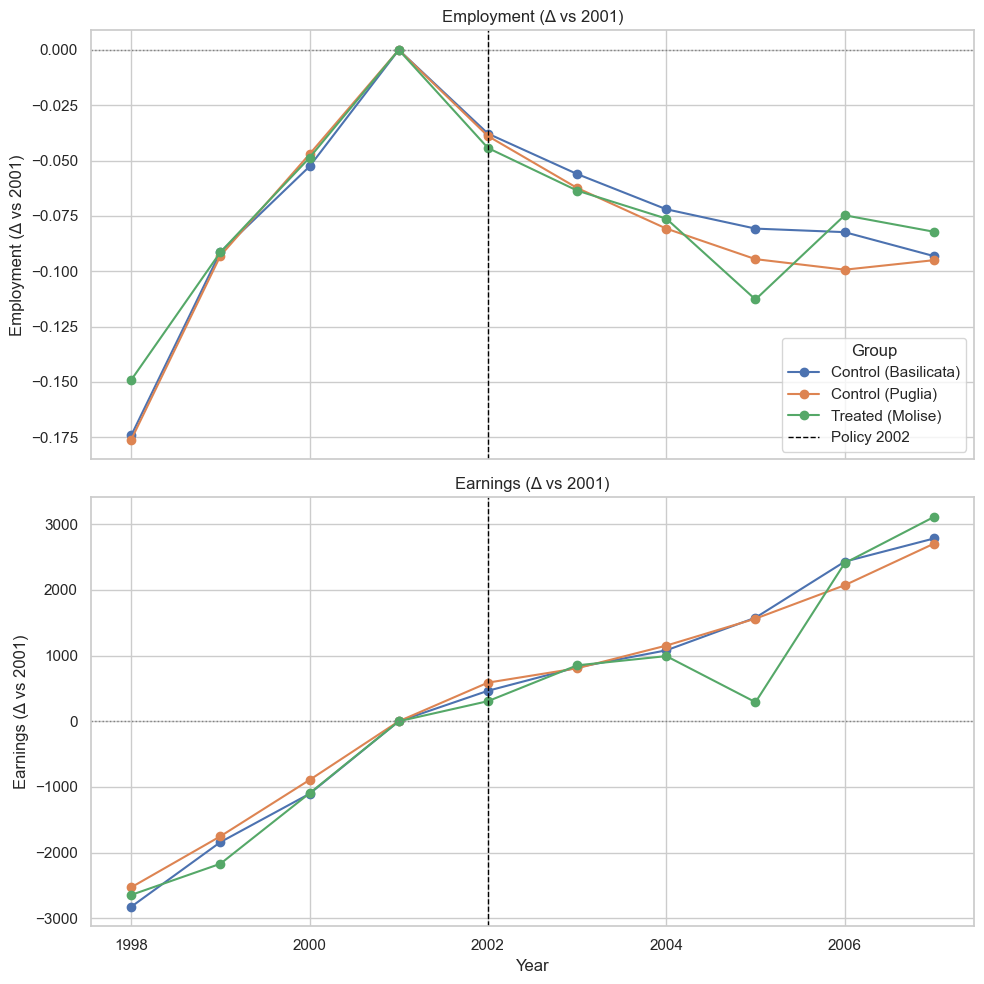

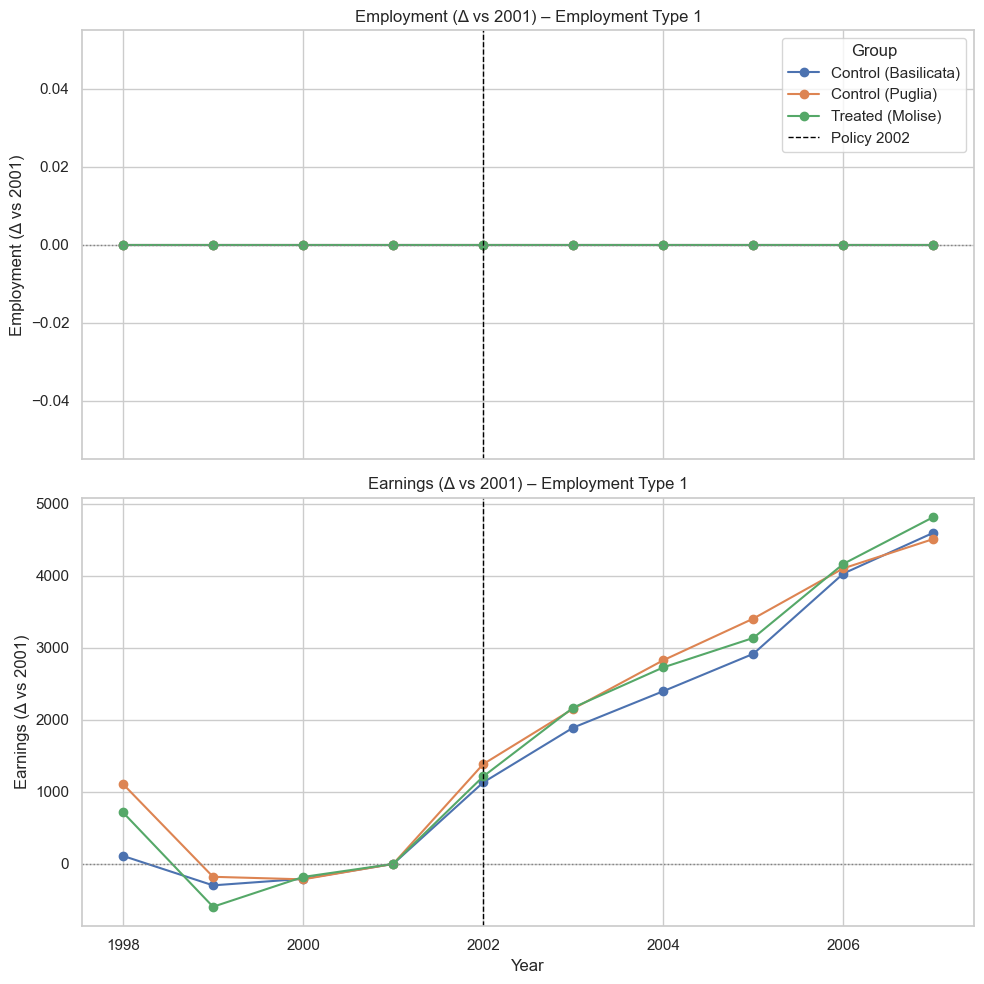

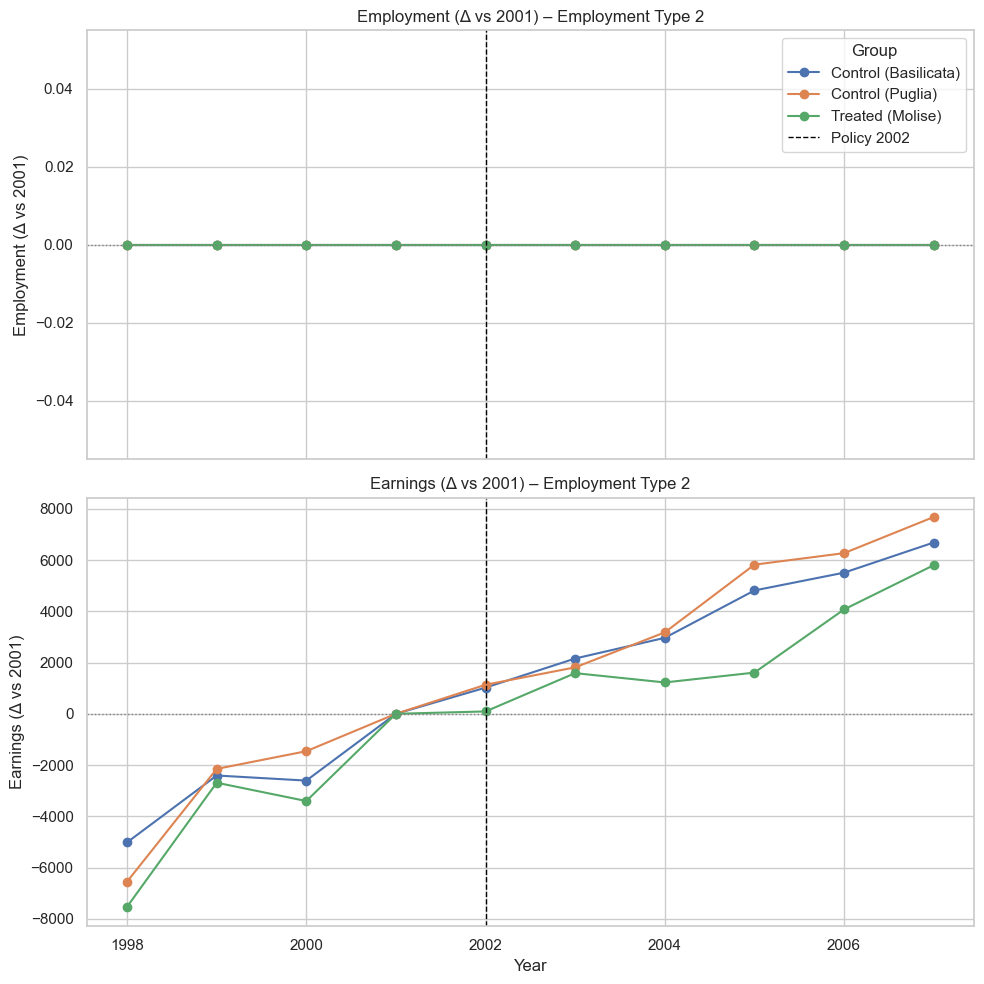

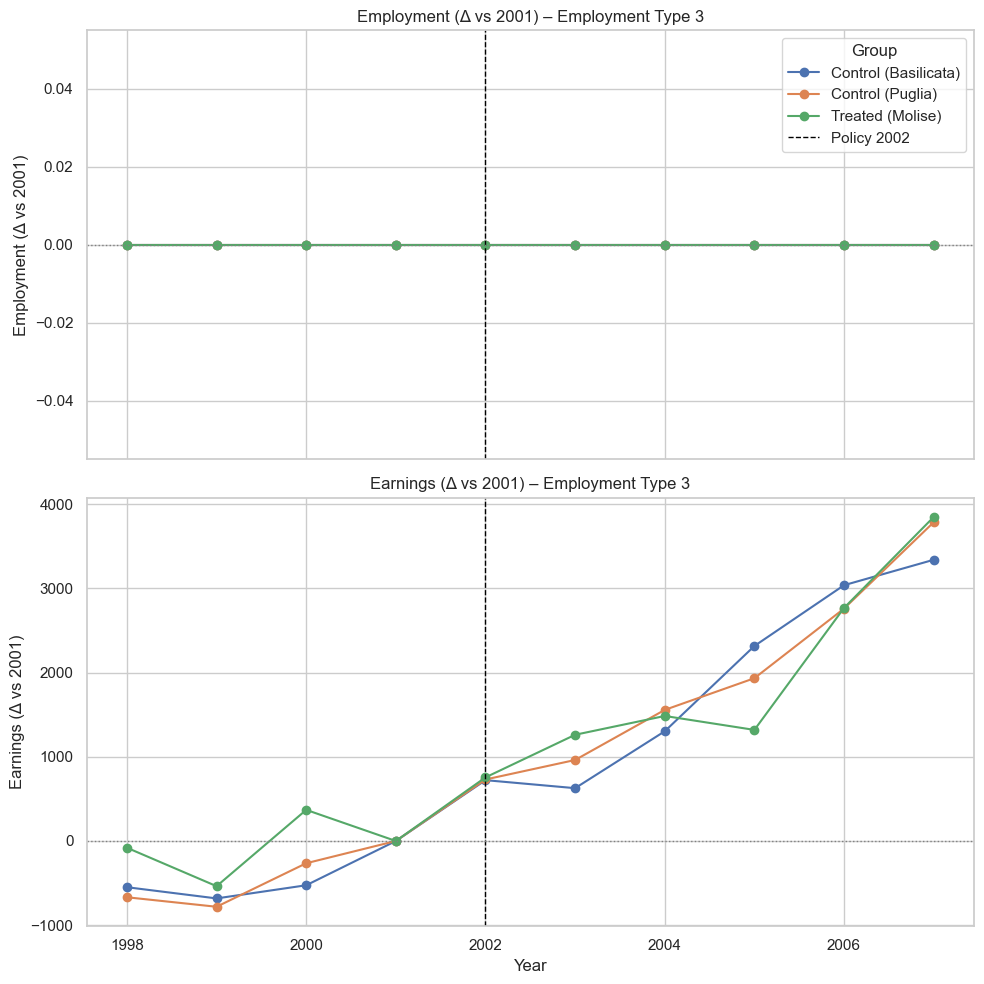

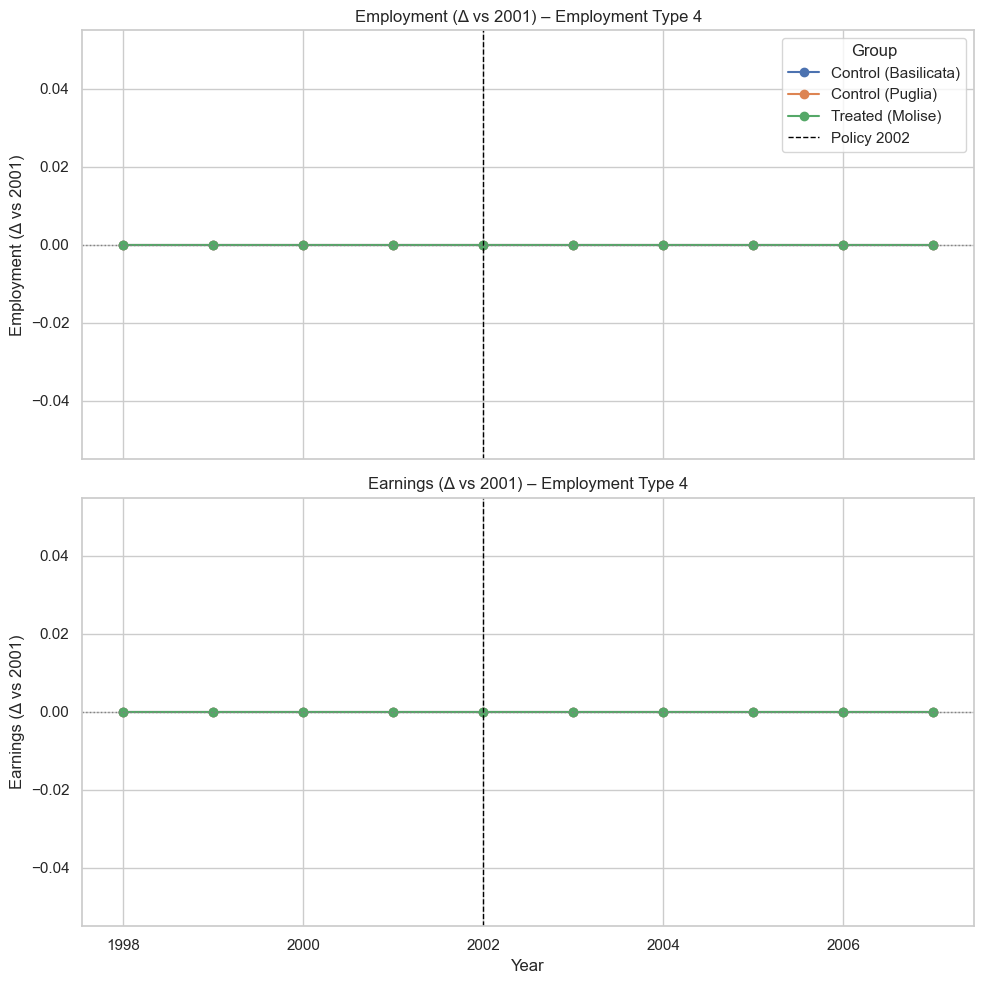

In [7]:
# Plot difference-index trajectories for employment and earnings
fig, axes = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
metrics = [("mean_emp_rel", "Employment (Δ vs 2001)"), ("mean_earn_rel", "Earnings (Δ vs 2001)")]

for ax, (metric, title) in zip(axes, metrics):
    for group_name, data in year_group.groupby("group"):
        label = GROUP_LABELS.get(group_name, group_name.title())
        ax.plot(data["year"], data[metric], marker="o", label=label)
    ax.axvline(2002, color="black", linestyle="--", linewidth=1, label="Policy 2002" if metric == "mean_emp_rel" else None)
    ax.axhline(0, color="grey", linestyle=":", linewidth=1)
    ax.set_ylabel(title)
    ax.set_title(title)

axes[0].legend(title="Group")
axes[-1].set_xlabel("Year")
plt.tight_layout()
plt.show()

# Employment-type trajectories (Δ vs 2001)
for employment_type in sorted(year_group_type["type"].dropna().unique()):
    type_data = year_group_type[year_group_type["type"] == employment_type]
    if type_data.empty:
        continue
    type_label = type_data["type_label"].iloc[0]

    fig, axes = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
    for ax, (metric, title) in zip(axes, metrics):
        for group_name, data in type_data.groupby("group"):
            label = GROUP_LABELS.get(group_name, group_name.title())
            ax.plot(data["year"], data[metric], marker="o", label=label)
        ax.axvline(2002, color="black", linestyle="--", linewidth=1, label="Policy 2002" if metric == "mean_emp_rel" else None)
        ax.axhline(0, color="grey", linestyle=":", linewidth=1)
        ax.set_ylabel(title)
        ax.set_title(f"{title} – {type_label}")

    axes[0].legend(title="Group")
    axes[-1].set_xlabel("Year")
    plt.tight_layout()
    plt.show()


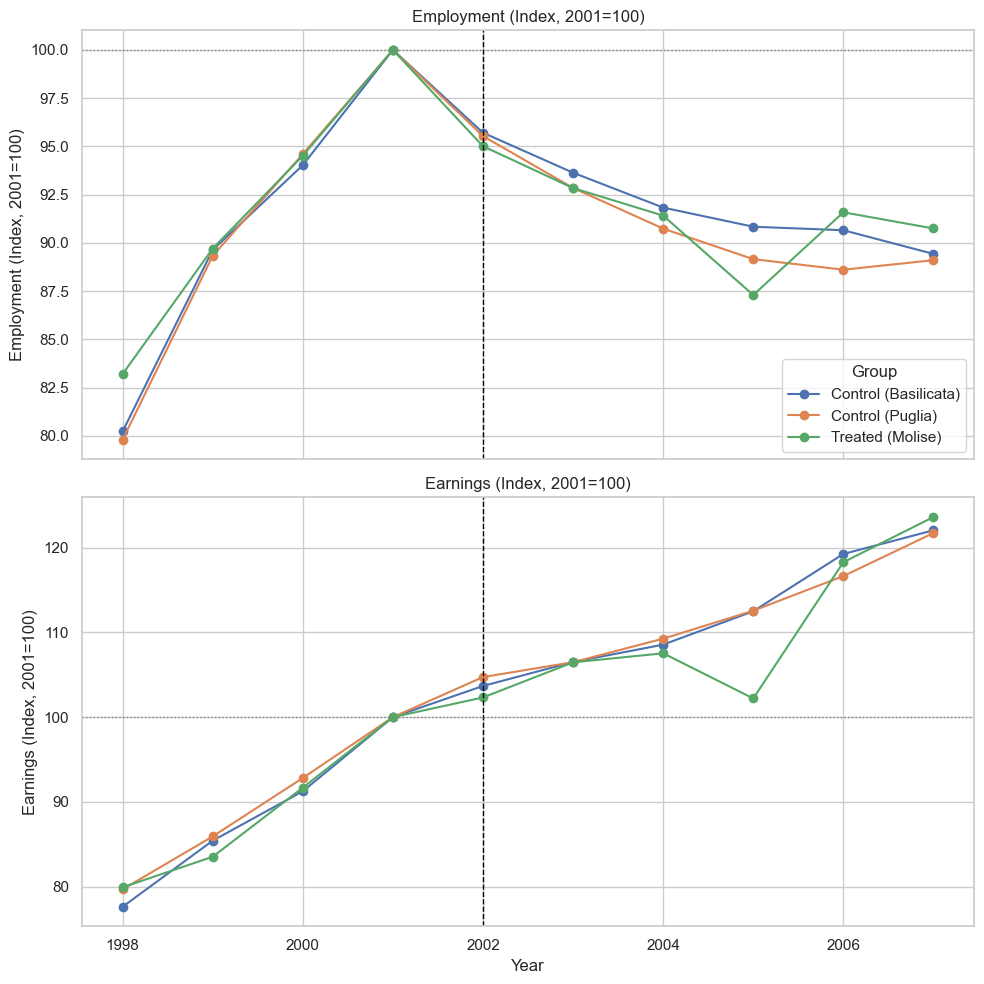

In [ ]:
# Optional: ratio index (2001 = 100)
fig, axes = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
metrics = [("mean_emp_ratio", "Employment (Index, 2001=100)"), ("mean_earn_ratio", "Earnings (Index, 2001=100)")]

for ax, (metric, title) in zip(axes, metrics):
    for group_name, data in year_group.groupby("group"):
        label = GROUP_LABELS.get(group_name, group_name.title())
        ax.plot(data["year"], data[metric], marker="o", label=label)
    ax.axvline(2002, color="black", linestyle="--", linewidth=1)
    ax.axhline(100, color="grey", linestyle=":", linewidth=1)
    ax.set_ylabel(title)
    ax.set_title(title)

axes[0].legend(title="Group")
axes[-1].set_xlabel("Year")
plt.tight_layout()
plt.show()

# Employment-type ratio indexes (2001 = 100)
for employment_type in sorted(year_group_type["type"].dropna().unique()):
    type_data = year_group_type[year_group_type["type"] == employment_type]
    if type_data.empty:
        continue
    type_label = type_data["type_label"].iloc[0]

    fig, axes = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
    for ax, (metric, title) in zip(axes, metrics):
        for group_name, data in type_data.groupby("group"):
            label = GROUP_LABELS.get(group_name, group_name.title())
            ax.plot(data["year"], data[metric], marker="o", label=label)
        ax.axvline(2002, color="black", linestyle="--", linewidth=1)
        ax.axhline(100, color="grey", linestyle=":", linewidth=1)
        ax.set_ylabel(title)
        ax.set_title(f"{title} – {type_label}")

    axes[0].legend(title="Group")
    axes[-1].set_xlabel("Year")
    plt.tight_layout()
    plt.show()


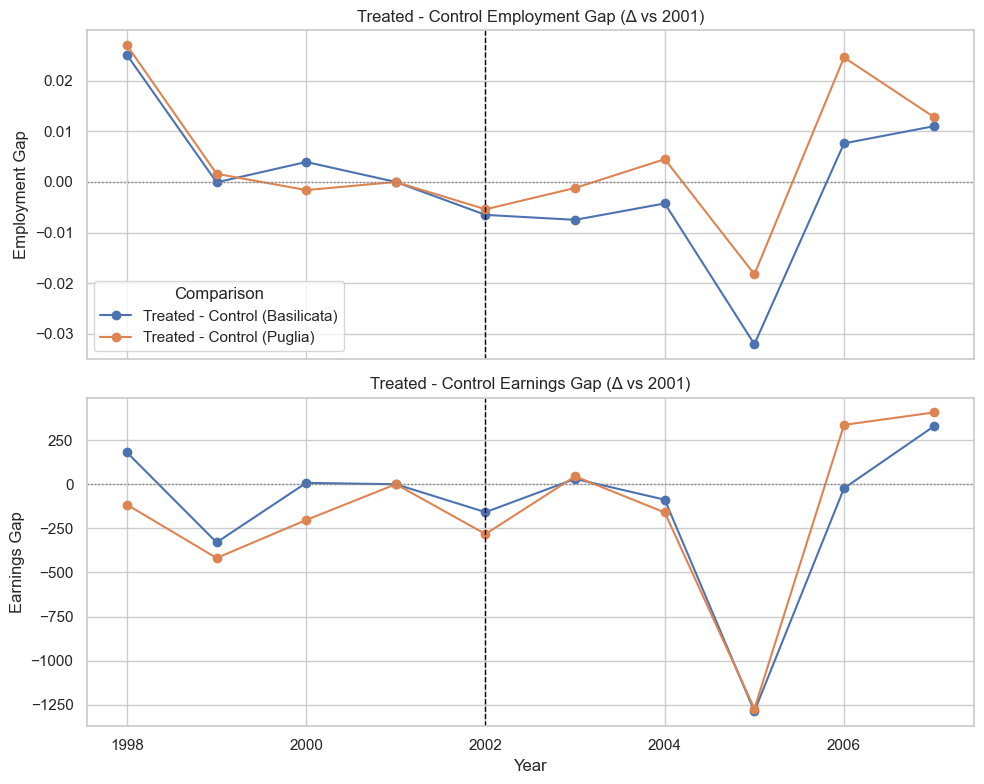

   year       control_group         control_label   emp_gap    earn_gap
0  1998  control_basilicata  Control (Basilicata)  0.025086  180.225114
1  1999  control_basilicata  Control (Basilicata) -0.000074 -329.644356
2  2000  control_basilicata  Control (Basilicata)  0.003947    7.652087
3  2001  control_basilicata  Control (Basilicata)       0.0         0.0
4  2002  control_basilicata  Control (Basilicata) -0.006503 -158.260729


In [24]:
# Treated-control gaps over time, normalized to 0 in 2001
pivot_rel = year_group.pivot(index="year", columns="group", values=["mean_emp_rel", "mean_earn_rel"])

treated_group = "treated_molise"
control_groups = [g for g in GROUP_LABELS if g != treated_group]

gap_frames = []
for control_group in control_groups:
    if (treated_group not in pivot_rel["mean_emp_rel"]) or (control_group not in pivot_rel["mean_emp_rel"]):
        continue
    gap_frames.append(
        pd.DataFrame({
            "year": pivot_rel.index,
            "control_group": control_group,
            "control_label": GROUP_LABELS.get(control_group, control_group.title()),
            "emp_gap": pivot_rel["mean_emp_rel", treated_group] - pivot_rel["mean_emp_rel", control_group],
            "earn_gap": pivot_rel["mean_earn_rel", treated_group] - pivot_rel["mean_earn_rel", control_group],
        })
    )

gap = pd.concat(gap_frames, ignore_index=True) if gap_frames else pd.DataFrame(columns=["year", "control_group", "control_label", "emp_gap", "earn_gap"])

fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
for ax, metric, title in zip(axes, ["emp_gap", "earn_gap"], ["Employment Gap", "Earnings Gap"]):
    for control_label, data in gap.groupby("control_label"):
        ax.plot(data["year"], data[metric], marker="o", label=f"Treated - {control_label}")
    ax.axvline(2002, color="black", linestyle="--", linewidth=1)
    ax.axhline(0, color="grey", linestyle=":", linewidth=1)
    ax.set_ylabel(title)
    ax.set_title(f"Treated - Control {title} (Δ vs 2001)")

axes[0].legend(title="Comparison")
axes[-1].set_xlabel("Year")
plt.tight_layout()
plt.show()

print(gap.head())
